# Overview

This notebook is a **short demo** part of the project for the [Big Data Computing AY2020/21 course](https://github.com/gtolomei/big-data-computing) teached by Prof. Gabriele Tolomei

Other resources:
- the [full version of this notebook](https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/3816168353014773/3331917203481792/3248872990014382/latest.html) including the training parts
- a [brief presentation](https://drive.google.com/file/d/1U7q5Gj-56AYK8tfbTeIhcAZjBH98TB51/view?usp=sharing) of this project

The project has been done by:
- Romeo Lanzino, matricola `1753403`, email `lanzino.1753403@studenti.uniroma1.it`
- Federico Fontana, matricola `1744946`, email `fontana.1744946@studenti.uniroma1.it`

<img src="https://www.chimicifisici.it/wp-content/uploads/2019/04/Sapienza_logo-1024x307.png" alt="drawing" width="400"/>

## Task
We have decided to tackle **semi-supervised multi-class images classification**, consisting of a dataset with both labeled and (a large amount of) unlabeled samples [_\[Van Engelen, Hoos, 2019, A survey on semi-supervised learning\]_](https://link.springer.com/content/pdf/10.1007/s10994-019-05855-6.pdf)

## Dataset
We've chosen [STL-10](https://cs.stanford.edu/~acoates/stl10/) [_\[Coates, Lee, Ng, 2011, An Analysis of Single Layer Networks in Unsupervised Feature Learning\]_](https://cs.stanford.edu/~acoates/papers/coatesleeng_aistats_2011.pdf), which is an image recognition dataset with a corpus of 100K unlabeled images, 500 labeled training images and 800 labeled test images, covering 10 different classes. 

Unlike [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) [_\[Krizhevsky, 2009, Learning Multiple Layers of Features from Tiny Images\]_](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf) (from which takes inspiration), the dataset has a higher resolution which makes it a challenging benchmark for developing more scalable unsupervised learning methods; the compressed
dataset weights 2.5GB, which seems a reasonable choice due to storage’s limitations of Databricks Community Edition

## Workflow

- download, analyze and **preprocess the dataset**
- contrast the curse of dimensionality using **dimensionality reduction** techniques such as a CNN
- **train a model** (such as a MLP) on the labeled training images
- **pseudo-label** the unlabeled images using the model trained in the previous step
- **train a second model** using also the pseudo-labeled images
- **evaluate** the results of both models to see if there have been some improvements
- implement an **image search engine** that, given a query image as input, returns a list of relevant images in a gallery (disjointed from the query images set) 

Each step will be covered in details in its respective section of this notebook

# Environment setup

## Global variables

This section contains references to variables used in this notebook, such as the learning rate of a model or the numbers of results the search engine will return for each query image

The following variables apply to PySpark's configuration

In [0]:
# how many rows per batch e.g. in @pandas_udf functions  
SPARK_MAX_RECORDS_PER_BATCH = 1e3
# how many bytes can a single partition store
SPARK_MAX_PARTITION_BYTES = 1e8

The following variables apply to the feature engineering part

In [0]:
# wheter to use a sample of df_unlabeled to reduce memory usage
USE_REDUCED_DF_UNLABELED = True

The following variables apply to the search engine part

In [0]:
# how many experiments with the search engine
# e.g. if SEARCH_ENGINE_QUERIES == 2, then a random image is selected as a query and their results are shown
# after that, a second random image is selected and their results are shown
SEARCH_ENGINE_QUERIES = 1
SEARCH_ENGINE_TOP_K_RESULTS = 8

## Setup

In [0]:
!pip install --upgrade pip 

import time

Requirement already satisfied: pip in /databricks/python3/lib/python3.8/site-packages (21.1.2)

In [0]:
spark.conf.set("spark.sql.execution.arrow.enabled", True)
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", int(SPARK_MAX_RECORDS_PER_BATCH))
spark.conf.set("spark.sql.files.maxPartitionBytes", int(SPARK_MAX_PARTITION_BYTES))

spark.catalog.clearCache()

In [0]:
starting_time = time.time()

# Data retrieval

In [0]:
import os
from os import makedirs
from os.path import join, exists
from pprint import pprint

!pip install gdown
import gdown

Requirement already satisfied: gdown in /databricks/python3/lib/python3.8/site-packages (3.13.0)
Requirement already satisfied: tqdm in /databricks/python3/lib/python3.8/site-packages (from gdown) (4.61.1)
Requirement already satisfied: requests[socks]>=2.12.0 in /databricks/python3/lib/python3.8/site-packages (from gdown) (2.24.0)
Requirement already satisfied: filelock in /usr/local/lib/python3.8/site-packages (from gdown) (3.0.12)
Requirement already satisfied: six in /usr/local/lib/python3.8/site-packages (from gdown) (1.15.0)
Requirement already satisfied: chardet<4,>=3.0.2 in /databricks/python3/lib/python3.8/site-packages (from requests[socks]>=2.12.0->gdown) (3.0.4)
Requirement already satisfied: idna<3,>=2.5 in /databricks/python3/lib/python3.8/site-packages (from requests[socks]>=2.12.0->gdown) (2.10)
Requirement already satisfied: urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1 in /databricks/python3/lib/python3.8/site-packages (from requests[socks]>=2.12.0->gdown) (1.25.11)
Requirement already satisfied: certifi>=2017.4.17 in /databricks/python3/lib/python3.8/site-packages (from requests[socks]>=2.12.0->gdown) (2020.12.5)
Requirement already satisfied: PySocks!=1.5.7,>=1.5.6 in /databricks/python3/lib/python3.8/site-packages (from requests[socks]>=2.12.0->gdown) (1.7.1)

## Download

The [STL-10 dataset](https://ai.stanford.edu/~acoates/stl10/) is available as `.bin` files containing Numpy arrays representing images and labels

Although this can be handy in other contexts, PySpark cannot natively load such files into a dataframe; common practice is to use known file types (such as `.csv`) that PySpark can easily read and parallelize with functions such as `spark.read`, so we needed to locally convert the `.bin` dataset to a more usable format

We've decided to use [`.parquet`](https://databricks.com/glossary/what-is-parquet), an open source file format designed for efficient as well as performant flat columnar storage format of data compared to row based files like `.csv` or `.tsv` files

The local preprocessing step roughly translates to:
- download the dataset in `.bin` format
- save each image-array as `.png`
- build three dataframes using PySpark or Pandas, since `.parquet` can be read from both frameworks: one for the labeled training images, another for the labeled test images and a last for the unlabeled images, each with a row for each image, a column containing the flattened arrays of the images and (for the labeled datasets only, of course) a column containing the labels of the images
- exports the three dataframes as `.parquet` files; note that a large dataframe can be exported as more than one `.parquet` file
- load the `.parquet` files somewhere on the web

After that, we're here able to directly download the `.parquet` files from a [shared Google Drive folder](https://drive.google.com/drive/folders/1te7m9u-FkjxYeopz1AG6N4wP-GoMDyBi?usp=sharing)

In [0]:
def download_stl10_parquet(path: str = ".") -> str:  
  stl10_parts_ids = [("stl10_train.parquet", "1OUDFIXnfhGRgxVS6NHmZfuXAkEEGEKHK"), 
                     ("stl10_test.parquet", "1UHN32csZqJEA3S94HS5PKpz3Y_OuJC2b"),
                     ("stl10_unlabeled_part1.parquet", "1VMFDf3haZRkCp_St6oP2pniAlq-c8lzS"), 
                     ("stl10_unlabeled_part2.parquet", "1mBuH0GrW_vB42i4WZovg_a8mTJlUvF0m"), 
                     ("stl10_unlabeled_part3.parquet", "1fM6ZBKWY34JS54XCRGwsedA_73VR0Wjo"), 
                     ("stl10_unlabeled_part4.parquet", "1aZkzLgk4UfvMl7nA6lOvF_fpRmXgUJ_J"), 
                     ("stl10_unlabeled_part5.parquet", "108YmXt-1pODfgTMl5LUFeSl8NIWroARU"), 
                     ("stl10_unlabeled_part6.parquet", "1XzPvGHbf33sm-EmE-1pcbWV1b1hmOvN4"), 
                     ("stl10_unlabeled_part7.parquet", "1-cKfFt-wRVLRq5Btekt9uGse4Cha-ZH1"), 
                     ("stl10_unlabeled_part8.parquet", "1VsIbWYSdZjnGm7hJw2dPVdkA8bTKuCK0")]
  stl10_path = join(path, "stl10_parquet")
  # creates the folders if needed
  if not exists(stl10_path):
    makedirs(stl10_path)
  if stl10_path not in [f.path.replace("dbfs:", "") for f in dbutils.fs.ls(f"{path}")]:
    dbutils.fs.mkdirs(stl10_path)
  # loops over each file id
  for stl10_part_filename, stl10_part_id in stl10_parts_ids:
    if stl10_part_filename not in [f.name.replace("dbfs:", "") for f in dbutils.fs.ls(stl10_path)]:
      # downloads the file
      print(f"Downloading 'https://drive.google.com/uc?id={stl10_part_id}' to '{join(stl10_path, stl10_part_filename)}'...")
      gdown.download(f"https://drive.google.com/uc?id={stl10_part_id}", join(stl10_path, stl10_part_filename), quiet=True)
      # sends the file to dbfs
      print(f"Copying '{join(stl10_path, stl10_part_filename)}' to 'dbfs:{join(stl10_path, stl10_part_filename)}'...")
      dbutils.fs.cp(f"file:{join(stl10_path, stl10_part_filename)}", f"dbfs:{join(stl10_path, stl10_part_filename)}")
  print(f"Everything synced")
  pprint([f.path for f in dbutils.fs.ls(f'{stl10_path}')])
  return stl10_path

In [0]:
# downloads the .parquet dataset into "dbfs:/tmp/stl10_parquet" folder 
stl10_path = download_stl10_parquet("/tmp")

Everything synced
['dbfs:/tmp/stl10_parquet/stl10_test.parquet',
 'dbfs:/tmp/stl10_parquet/stl10_train.parquet',
 'dbfs:/tmp/stl10_parquet/stl10_unlabeled_part1.parquet',
 'dbfs:/tmp/stl10_parquet/stl10_unlabeled_part2.parquet',
 'dbfs:/tmp/stl10_parquet/stl10_unlabeled_part3.parquet',
 'dbfs:/tmp/stl10_parquet/stl10_unlabeled_part4.parquet',
 'dbfs:/tmp/stl10_parquet/stl10_unlabeled_part5.parquet',
 'dbfs:/tmp/stl10_parquet/stl10_unlabeled_part6.parquet',
 'dbfs:/tmp/stl10_parquet/stl10_unlabeled_part7.parquet',
 'dbfs:/tmp/stl10_parquet/stl10_unlabeled_part8.parquet']

## Loading into PySpark

Datasets are then directly read from `dbfs` using Spark's `spark.read.parquet` built-in function

As the unlabeled part of the dataset is split into several smaller `.parquet` files, they are sequentially read and merged together into a single dataframe

In [0]:
from pyspark.sql.types import StringType, ArrayType, FloatType, ByteType
from pyspark.sql.functions import monotonically_increasing_id

In [0]:
# prepares the paths
df_test_path = "dbfs:/tmp/stl10_parquet/stl10_test.parquet"
df_unlabeled_paths = [path.path for path in dbutils.fs.ls(stl10_path) if "unlabeled" in path.name]

# reads the dataframes
df_test = spark.read.parquet(df_test_path)
if USE_REDUCED_DF_UNLABELED:
  df_unlabeled = spark.read.parquet(df_unlabeled_paths[0]) 
else:
  df_unlabeled = spark.read.parquet(*[path.path for path in dbutils.fs.ls(stl10_path) if "unlabeled" in path.name]) 
df_unlabeled = df_unlabeled.sample(0.05)

Since the datasets are huge with respect to our cluster, we compress each number in the flattened arrays of `image` column from `IntegerType` (4 bytes, in \\([-2147483648, 2147483647]\\)) to `ByteType` (1 byte, in \\([-128, 127]\\))

Numbers in the original files are in \\([0, 255]\\), so we don't have a loss of informations after such transformation

Here you can find [more infos on PySpark's data types](https://spark.apache.org/docs/latest/sql-ref-datatypes.html)

In [0]:
# "compresses" the images column 
image_as_byte = udf(lambda values: [int(value) for value in values], ArrayType(ByteType()))
df_test = df_test.withColumn("image", image_as_byte(df_test["image"]))
df_unlabeled = df_unlabeled.withColumn("image", image_as_byte(df_unlabeled["image"]))

To uniquely identify each image in a dataframe, we'll add an `id` column containing a unique randomly generated integer for each row using a [PySpark's native transformation](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.functions.monotonically_increasing_id.html)

In [0]:
# adds an id column
df_test = df_test.withColumn("id", monotonically_increasing_id())
df_unlabeled = df_unlabeled.withColumn("id", monotonically_increasing_id())

Since we do have to access these dataframes until the end of the notebook, it makes sense to cache them to have them always ready

In [0]:
df_test.cache()
df_unlabeled.cache()

Out[14]: DataFrame[image: array<tinyint>, id: bigint]

# Features engineering

## Preliminary data analysis

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

!pip install Pillow
!pip install torch==1.8.1+cpu torchvision==0.9.1+cpu -f https://download.pytorch.org/whl/torch_stable.html
import torch
from torch import nn
import torchvision
from torchvision import transforms as T

from pyspark.sql.dataframe import DataFrame
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, udf, count
from pyspark.ml.linalg import Vectors, VectorUDT

Requirement already satisfied: Pillow in /databricks/python3/lib/python3.8/site-packages (8.2.0)
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Requirement already satisfied: torch==1.8.1+cpu in /databricks/python3/lib/python3.8/site-packages (1.8.1+cpu)
Requirement already satisfied: torchvision==0.9.1+cpu in /databricks/python3/lib/python3.8/site-packages (0.9.1+cpu)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.8/site-packages (from torch==1.8.1+cpu) (1.19.2)
Requirement already satisfied: typing-extensions in /databricks/python3/lib/python3.8/site-packages (from torch==1.8.1+cpu) (3.10.0.0)
Requirement already satisfied: pillow>=4.1.1 in /databricks/python3/lib/python3.8/site-packages (from torchvision==0.9.1+cpu) (8.2.0)

The dataset is composed by three dataframes:

- `df_train`, which contains 5,000 labeled training images
- `df_test`, which contains 8,000 labeled test images
- `df_unlabeled`, which contains 100,000 unlabeled images

In [0]:
print(f"|df_unlabeled| = {df_unlabeled.count()} (in {df_unlabeled.rdd.getNumPartitions()} partitions)")
df_unlabeled.show(n=4)

print(f"|df_test| = {df_test.count()} (in {df_test.rdd.getNumPartitions()} partitions)")
df_test.show(n=4)

|df_unlabeled| = 600 (in 4 partitions)
+--------------------+----------+
 image| id|
+--------------------+----------+
[0, 0, 0, 0, 0, 0...|8589934592|
[0, 0, 0, 0, 0, 0...|8589934593|
[-1, -1, -1, -1, ...|8589934594|
[101, 105, 107, 1...|8589934595|
+--------------------+----------+
only showing top 4 rows

df_test| = 8000 (in 3 partitions)
+--------------------+--------+----------+
 image| label| id|
+--------------------+--------+----------+
[47, 91, -104, 47...|airplane|8589934592|
[-92, -95, -102, ...|airplane|8589934593|
[-67, -64, -71, -...|airplane|8589934594|
[51, -109, -7, 52...|airplane|8589934595|
+--------------------+--------+----------+
only showing top 4 rows

## Dimensionality reduction

In order to reduce the dimensionality of image (represented by \\(96 \times 96 \times 3\\) integers) and contrast the **curse of dimensionality** phenomena, one can exploit different **dimensionality reduction techniques**:

- **PCA**: reduce the dimensionality of a dataset while preserving as much 'variability' (i.e. statistical information) as possible. The standard context for PCA as an exploratory data analysis tool involves a dataset with observations on \\( p \\) numerical variables, for each of \\( n \\) entities or individuals. These data values define  an \\( n \times p \\) data matrix \\( X \\), whose \\( j \\)th column is the vector \\( x_t \\) of observations on the \\( j \\)th variable. From that, we seek a linear combination of the columns of matrix \\(X\\) with maximum variance [\[Jolliffe, Cadima, 2016\]](https://royalsocietypublishing.org/doi/10.1098/rsta.2015.0202)
- **CNN**: it is common practice to use as-is or fine-tune pretrained convolutional neural networks as backbones for images' dimensionality reduction: is it possible to feed an image to this backbone and take image's representation (embeddings) just before the last classification layer to have a meaningful, reduced represention of the input

For computational purposes we'll choose a CNN model with a low number of parameters to speed-up the computation: [SqueezeNet 1.0](https://pytorch.org/hub/pytorch_vision_squeezenet/)

In [0]:
# loops over different PyTorch's models
for model_name, model in [("ResNet18", torchvision.models.resnet18), 
                          ("MobileNet v3-small", torchvision.models.mobilenet_v3_small),
                          ("SqueezeNet 1.0", torchvision.models.squeezenet1_0)]:
  # retrieves the number of parameters of the model
  parameters = sum(p.numel() for p in model(pretrained=False).parameters())
  print(f"{model_name} has {parameters} parameters")

ResNet18 has 11689512 parameters
MobileNet v3-small has 2542856 parameters
SqueezeNet 1.0 has 1248424 parameters

This cell downloads and instantiate a pretrained version of the CNN

Since SqueezeNet requires normalized images' colors, each image fed to it needs to be preprocessed [(more about it)](https://pytorch.org/vision/stable/models.html)

In [0]:
# retrieves the backbone model
squezze =torchvision.models.squeezenet1_0(pretrained=True) 
mobilev3small=torchvision.models.mobilenet_v3_small(pretrained=True) 

  
model = nn.Sequential(
  mobilev3small.features, 
  mobilev3small.avgpool, 
  torch.nn.Flatten(1),
  mobilev3small.classifier[0]
  #squezze.features,
  #squezze.classifier
)

# freezes model's parameters
model.eval()
for p in model.parameters():
  p.requires_grad = False
  
# transformations to do on each image before processing it
image_preprocessing = T.Compose([
  T.Normalize(mean=[0.485, 0.456, 0.406], 
              std=[0.229, 0.224, 0.225]),
  T.Resize((224,224))
])

The following function parallelizes embeddings' generation using a [`@pandas_udf`](https://docs.databricks.com/spark/latest/spark-sql/udf-python-pandas.html) function

The code is inspired by [a DataBricks team's tutorial notebook](https://docs.databricks.com/_static/notebooks/deep-learning/pytorch-images.html)

In [0]:
@pandas_udf(ArrayType(FloatType()))
def predict_emb(image_batch_iter: pd.Series) -> pd.Series:
  images = np.vstack([i for i in image_batch_iter])
  images[images < 0] += 256
  images = images / 255
  images = torch.from_numpy(images).type(torch.float32)
  images = torch.reshape(images, (-1, 96, 96, 3))
  images = images.permute(0, 3, 1, 2)
  images = image_preprocessing(images)
  with torch.no_grad():
    preds = model(images)
  preds = torch.reshape(preds, (-1, 1024)).tolist()
  return pd.Series(preds)

Here a new column called `embeddings` is generated, containing the embeddings of the images

In [0]:
df_unlabeled = df_unlabeled.withColumn("embeddings", predict_emb(df_unlabeled["image"]))
df_test = df_test.withColumn("embeddings", predict_emb(df_test["image"]))

Since PySpark's models expects `VectorUDT` to represent arrays in dataframes, the `embeddings` column is converted from arrays of floats to `VectorUDT`

In [0]:
# converts embeddings to VectorUDT
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
df_test = df_test.withColumn("embeddings", list_to_vector_udf(df_test["embeddings"]))
df_unlabeled = df_unlabeled.withColumn("embeddings", list_to_vector_udf(df_unlabeled["embeddings"]))

To better organize the memory, we'll create different datasets for the embeddings, the ones whose name ends with `_emb`

For example:
- `df_train` will contain the `image` column but not the `embeddings` one
- `df_train_emb` will contain the `embeddings` column but not the `image` one

In [0]:
# saves just the embedding dataframes
df_test_emb = df_test.drop("image")
df_unlabeled_emb = df_unlabeled.drop("image")

# caches the embeddings dataframes for faster use
df_test_emb.cache()
df_unlabeled_emb.cache()

Out[22]: DataFrame[id: bigint, embeddings: vector]

# Loading the models

In [0]:
!pip install mlflow

import json
from pyspark.ml.classification import MultilayerPerceptronClassifier, MultilayerPerceptronClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidatorModel

Requirement already satisfied: mlflow in /databricks/python3/lib/python3.8/site-packages (1.17.0)
Requirement already satisfied: gitpython>=2.1.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (3.1.17)
Requirement already satisfied: gunicorn in /databricks/python3/lib/python3.8/site-packages (from mlflow) (20.1.0)
Requirement already satisfied: alembic<=1.4.1 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.4.1)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.19.2)
Requirement already satisfied: protobuf>=3.6.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (3.17.3)
Requirement already satisfied: databricks-cli>=0.8.7 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.14.3)
Requirement already satisfied: entrypoints in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.3)
Requirement already satisfied: prometheus-flask-exporter in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.18.2)
Requirement already satisfied: click>=7.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (8.0.1)
Requirement already satisfied: docker>=4.0.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (5.0.0)
Requirement already satisfied: pyyaml in /databricks/python3/lib/python3.8/site-packages (from mlflow) (5.4.1)
Requirement already satisfied: sqlalchemy in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.4.18)
Requirement already satisfied: cloudpickle in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.6.0)
Requirement already satisfied: querystring-parser in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.2.4)
Requirement already satisfied: sqlparse>=0.3.1 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.4.1)
Requirement already satisfied: pandas in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.1.3)
Requirement already satisfied: requests>=2.17.3 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2.24.0)
Requirement already satisfied: pytz in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2020.5)
Requirement already satisfied: Flask in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2.0.1)
Requirement already satisfied: python-dateutil in /databricks/python3/lib/python3.8/site-packages (from alembic<=1.4.1->mlflow) (2.8.1)
Requirement already satisfied: python-editor>=0.3 in /databricks/python3/lib/python3.8/site-packages (from alembic<=1.4.1->mlflow) (1.0.4)
Requirement already satisfied: Mako in /databricks/python3/lib/python3.8/site-packages (from alembic<=1.4.1->mlflow) (1.1.4)
Requirement already satisfied: tabulate>=0.7.7 in /databricks/python3/lib/python3.8/site-packages (from databricks-cli>=0.8.7->mlflow) (0.8.9)
Requirement already satisfied: six>=1.10.0 in /usr/local/lib/python3.8/site-packages (from databricks-cli>=0.8.7->mlflow) (1.15.0)
Requirement already satisfied: websocket-client>=0.32.0 in /databricks/python3/lib/python3.8/site-packages (from docker>=4.0.0->mlflow) (1.1.0)
Requirement already satisfied: gitdb<5,>=4.0.1 in /databricks/python3/lib/python3.8/site-packages (from gitpython>=2.1.0->mlflow) (4.0.7)
Requirement already satisfied: smmap<5,>=3.0.1 in /databricks/python3/lib/python3.8/site-packages (from gitdb<5,>=4.0.1->gitpython>=2.1.0->mlflow) (4.0.0)
Requirement already satisfied: certifi>=2017.4.17 in /databricks/python3/lib/python3.8/site-packages (from requests>=2.17.3->mlflow) (2020.12.5)
Requirement already satisfied: idna<3,>=2.5 in /databricks/python3/lib/python3.8/site-packages (from requests>=2.17.3->mlflow) (2.10)
Requirement already satisfied: urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1 in /databricks/python3/lib/python3.8/site-packages (from requests>=2.17.3->mlflow) (1.25.11)
Requirement already satisfied: chardet<4,>=3.0.2 in /databricks/python3/lib/python3.8/

In [0]:
# loads the labels
dbutils.fs.cp(f"dbfs:/labels.json", f"file:/databricks/driver/labels.json")
with open("labels.json", 'r', encoding='utf-8') as fp:
  labels_map = json.load(fp)

print(f"Labels with mapped integer:")
pprint(labels_map)

# adds a column for the mapped labels
map_label = udf(lambda l: labels_map[l], IntegerType())
df_test_emb = df_test_emb.withColumn("label_mapped", map_label(df_test_emb.label)).drop("label")

Labels with mapped integer:
{'airplane': 0,
 'bird': 1,
 'car': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'horse': 6,
 'monkey': 7,
 'ship': 8,
 'truck': 9}

PySpark offers [several types of classifiers](https://spark.apache.org/docs/latest/ml-classification-regression.html#classification), and it's crucial to empirically investigate which one works better for a given dataset

Since our data is continuous, we can already think that classifiers such as [Random Forests](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.RandomForestClassifier.html) are probably not a good choice

After some tests we've found [Multilayer Perceptron (MLP)](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.MultilayerPerceptronClassifier.html) to work slightly better than the other classifiers

The training of the model will take several minutes to complete

In [0]:
# defines the model
base_model = MultilayerPerceptronClassificationModel.load("dbfs:/base_model")
final_model = CrossValidatorModel.load("dbfs:/final_model")

# Models' evaluation

It is common to evaluate multi-class classification results on different metrics

PySpark has a [built-in evaluator](https://spark.apache.org/docs/latest//api/python/reference/api/pyspark.ml.evaluation.MulticlassClassificationEvaluator.html) for our needs, that computes different performances results based on different metrics:
- [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification): proportion of correct predictions (both true positives and true negatives) among the total number of cases examined
- [precision](https://en.wikipedia.org/wiki/Precision_and_recall#Precision): number of correct results divided by the number of all returned results
- [recall](https://en.wikipedia.org/wiki/Precision_and_recall#Recall): number of correct results divided by the number of results that should have been returned
- [F1 score](https://en.wikipedia.org/wiki/F-score): harmonic mean of precision and recall

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [0]:
evaluation_results = {}
for model_name, model in [("base model", base_model), 
                          ("final model", final_model)]:
  df_test_results = model.transform(df_test_emb).select("probability", "label_mapped", "label_mapped_pred")
  df_test_results.cache()
  for metric in ["accuracy", "f1", "weightedPrecision", "weightedRecall", "weightedTruePositiveRate", "weightedFalsePositiveRate"]:
    evaluation_results[metric] = MulticlassClassificationEvaluator(predictionCol="label_mapped_pred", labelCol="label_mapped", probabilityCol="probability", 
                                                                   metricName=metric).evaluate(df_test_results)
  print(f"Evaluation results on df_test using {model_name}:")
  pprint(evaluation_results)
  print()
  df_test_results.unpersist()

Evaluation results on df_test using base model:
{'accuracy': 0.669375,
 'f1': 0.6717551753303268,
 'weightedFalsePositiveRate': 0.036736111111111115,
 'weightedPrecision': 0.680093714461409,
 'weightedRecall': 0.669375,
 'weightedTruePositiveRate': 0.669375}

Evaluation results on df_test using final model:
{'accuracy': 0.660375,
 'f1': 0.6616909977888196,
 'weightedFalsePositiveRate': 0.03773611111111111,
 'weightedPrecision': 0.6654451885476704,
 'weightedRecall': 0.660375,
 'weightedTruePositiveRate': 0.660375}

# Search engine prototype

In [0]:
from typing import List, Dict

from scipy.spatial.distance import cosine

from pyspark.sql.types import Row
from pyspark.sql.dataframe import DataFrame
from pyspark.sql.functions import monotonically_increasing_id 

In [0]:
def get_random_rows(df: DataFrame, n: int = 1) -> List[Row]:
  assert isinstance(df, DataFrame)
  assert isinstance(n, int) and n <= df.count()
  # retrieves random rows
  rows = df.sample((n+1) / df.count()).take(n)
  return rows   
  
def kullback_leibler(P: np.ndarray, Q: np.ndarray) -> float:
  epsilon = 0.00001
  P, Q = P + epsilon, Q + epsilon
  divergence = np.sum(P*np.log(P/Q))
  return divergence

In [0]:
def plot_similar_images(row_query: Row, df_gallery: DataFrame, k: int = 8) -> Dict[str, Dict[str, DataFrame]]:
  assert isinstance(row_query, Row)
  assert isinstance(df_gallery, DataFrame)
  assert isinstance(k, int) and k >= 1
  
  # retrieves the distances between images in gallery
  get_prob_kl_dist = udf(lambda value: float(kullback_leibler(row_query["probability"], value)), FloatType())
  get_prob_l2_dist = udf(lambda value: float((row_query["probability"]-value).norm(2)), FloatType())
  get_emb_l2_dist = udf(lambda value: float((row_query["embeddings"]-value).norm(2)), FloatType())
  get_emb_cos_dist = udf(lambda value: float(cosine(row_query["embeddings"], value)), FloatType())
  
  df_gallery_queried = df_gallery
  df_gallery_queried = df_gallery_queried.withColumn("prob_kl_dist",
                                                     get_prob_kl_dist(df_gallery["probability"]))
  df_gallery_queried = df_gallery_queried.withColumn("prob_l2_dist",
                                                     get_prob_l2_dist(df_gallery["probability"]))
  df_gallery_queried = df_gallery_queried.withColumn("emb_l2_dist", 
                                                     get_emb_l2_dist(df_gallery["embeddings"]))
  df_gallery_queried = df_gallery_queried.withColumn("emb_cos_dist", 
                                                     get_emb_cos_dist(df_gallery["embeddings"]))
  df_gallery_queried = df_gallery_queried.drop("embeddings", "probability")
  
  # unflattens query image
  query_image = np.asarray(df_test.filter(df_test.id == row_query.id).first().image)
  side = int(np.sqrt(len(query_image)/3))
  query_image = np.reshape(query_image, (side, side, 3))
  query_image[query_image < 0] += 256
  
  results = {}
  # loops over criterions
  for criterion, column_name in [(f"Kullback–Leibler divergence on probabilities", "prob_kl_dist"), 
                                 (f"L2 distance on probabilities", "prob_l2_dist"),
                                 (f"L2 distance on embeddings", "emb_l2_dist"),
                                 (f"cosine distance on embeddings", "emb_cos_dist")]:
    # retrieves the results
    df_scores = df_gallery_queried.sort(df_gallery_queried[column_name].asc())
    df_scores_best = df_scores.sort(df_scores[column_name].asc())
    df_scores_worst = df_scores.sort(df_scores[column_name].desc())
    
    df_images_best = df_unlabeled.where(col("id").isin([row["id"] for row in df_scores_best.take(k)]))
    df_images_worst = df_unlabeled.where(col("id").isin([row["id"] for row in df_scores_worst.take(k)]))
    
    df_results_best = df_images_best.join(df_scores, "id", "inner").sort(df_gallery_queried[column_name].asc())
    df_results_worst = df_images_worst.join(df_scores, "id", "inner").sort(df_gallery_queried[column_name].asc())
    
    results[column_name] = {"best": df_results_best, 
                            "worst": df_results_worst}
    
    # creates the layout for the plot
    fig = plt.figure(figsize=((2+k)*2, 2*2))
    gs = fig.add_gridspec(2, 2+k)
    # plots the query image
    ax_query = plt.subplot(gs[0:2, 0:2])
    ax_query.set_title(f"query image ({row_query['label_pred']})", fontsize=12)
    ax_query.imshow(query_image)
    # gets the axes for the results
    axes_best, axes_worst = [], []
    for x in range(2):
      for y in range(2, 2+k):
        ax = plt.subplot(gs[x, y])
        if x == 0:
          axes_best += [ax]
        elif x == 1:
          axes_worst += [ax]
    # hides ticks
    for ax in [ax_query] + axes_best + axes_worst:
      ax.axes.xaxis.set_visible(False)
      ax.axes.yaxis.set_visible(False)
    # plots the images
    for axes, df_results in [(axes_best, df_results_best), 
                             (axes_worst, df_results_worst)]:
      for ax, row in zip(axes, df_results.collect()):
        image = row["image"]
        image = np.reshape(image, (side, side, 3))
        image[image < 0] += 256
        ax.set_title(f"d = {np.round(row[column_name], 5)} ({row['label_pred']})", fontsize=8)
        ax.imshow(image)
    fig.suptitle(f"{df_results_best.count()} more similar and {df_results_worst.count()} less similar images in gallery based on {criterion}", fontsize=14)
    plt.show()
  return results

## Gallery set generation

It is natural for us to use `df_unlabeled` as gallery set because is the biggest one and because images inside it are extracted from a similar but broader distribution of images, for example containing other types of animals and vehicles in addition to the ones in the labeled dataframes

In [0]:
df_gallery_emb = base_model.transform(df_unlabeled_emb).select("id", "embeddings", "probability", "label_mapped_pred")

unmap_label = udf(lambda l: {v: k for k, v in labels_map.items()}[int(l)], StringType())
df_gallery_emb = df_gallery_emb.withColumn("label_pred", unmap_label(df_gallery_emb.label_mapped_pred)).drop("label_mapped_pred")

df_gallery_emb.cache()
df_unlabeled_emb.unpersist()

Out[31]: DataFrame[id: bigint, embeddings: vector]

In [0]:
df_gallery_emb.printSchema()
df_gallery_emb.show(4)

root
-- id: long (nullable = false)
-- embeddings: vector (nullable = true)
-- probability: vector (nullable = true)
-- label_pred: string (nullable = true)

+----------+--------------------+--------------------+----------+
 id| embeddings| probability|label_pred|
+----------+--------------------+--------------------+----------+
8589934592|[-1.2112901210784...|[0.99281058327789...| airplane|
8589934593|[-1.0154033899307...|[0.01040343021810...| car|
8589934594|[-0.4540418088436...|[2.66186629050106...| truck|
8589934595|[0.06425315141677...|[9.97140057572421...| dog|
+----------+--------------------+--------------------+----------+
only showing top 4 rows

## Query set setup

Query images must be extracted from a set disjointed from the gallery

For this purpose, we'll use `df_test`

In [0]:
df_query_emb = final_model.transform(df_test_emb).select("id", "embeddings", "probability", "label_mapped_pred")

df_query_emb = df_query_emb.withColumn("label_pred", unmap_label(df_query_emb["label_mapped_pred"])).drop("label_mapped_pred")

df_query_emb.cache()
df_test_emb.unpersist()

Out[33]: DataFrame[id: bigint, embeddings: vector, label_mapped: int]

In [0]:
df_query_emb.printSchema()
df_query_emb.show(4)

root
-- id: long (nullable = false)
-- embeddings: vector (nullable = true)
-- probability: vector (nullable = true)
-- label_pred: string (nullable = true)

+----------+--------------------+--------------------+----------+
 id| embeddings| probability|label_pred|
+----------+--------------------+--------------------+----------+
8589934592|[-3.0076751708984...|[0.94404764445835...| airplane|
8589934593|[-1.2043626308441...|[0.98682372076891...| airplane|
8589934594|[0.42445918917655...|[0.99906132055771...| airplane|
8589934595|[-0.2033578157424...|[0.95025618700572...| airplane|
+----------+--------------------+--------------------+----------+
only showing top 4 rows

## Similar images retrieval

For each query image, the system will find the \\(k\\) more similar (less distant) and the \\(k\\) less similar (more distant) for each of the distance measures used:
- [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) on classification probabilities scores
- L2 distance on SqueezeNet's embeddings
- cosine distance

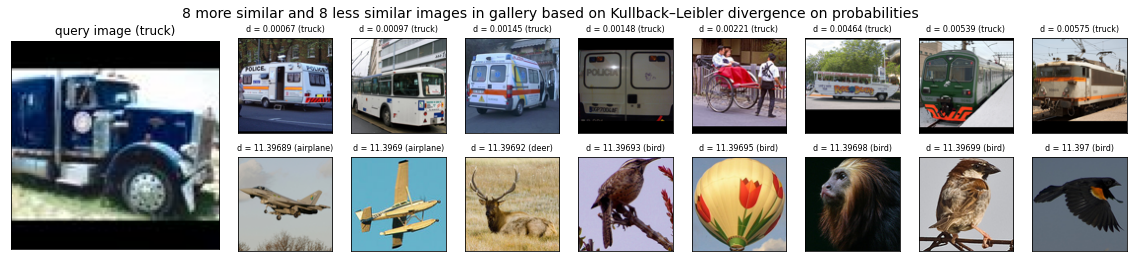

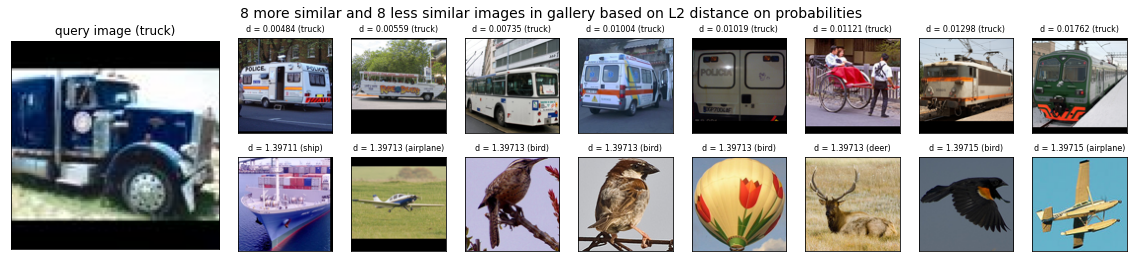

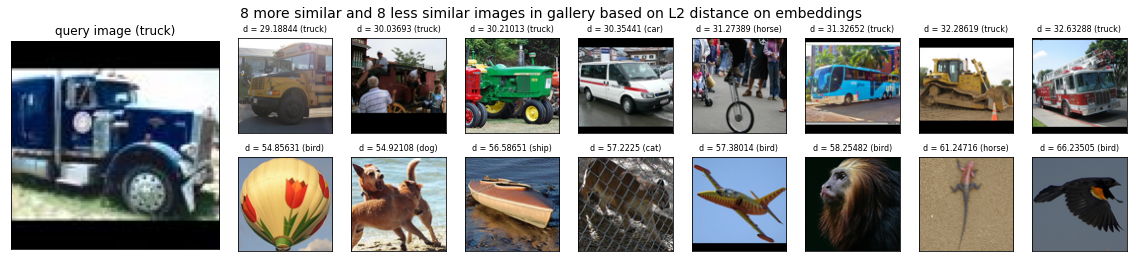

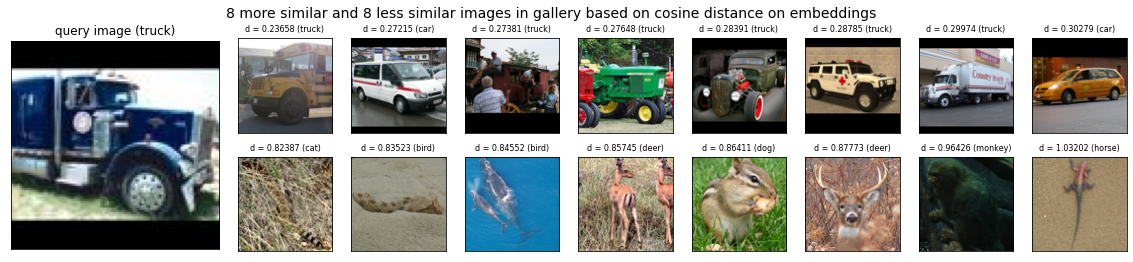

In [0]:
for row_query in get_random_rows(df=df_query_emb, n=SEARCH_ENGINE_QUERIES):
    plot_similar_images(row_query=row_query, df_gallery=df_gallery_emb, k=SEARCH_ENGINE_TOP_K_RESULTS)

In [0]:
print(f"Total execution time: {np.round((time.time() - starting_time)/60, 1)} minutes")

Total execution time: 8.1 minutes